In [1]:
from utils import MinnieData
import numpy as np 
mdata = MinnieData()


sst_neurons = mdata.get_fully_extended(mdata.get_cells_stype('sst')['pt_root_id'])
l23_neurons = mdata.get_dorkenwald_neurons_l23()['pre']
sst_positions = np.vstack(mdata.position(sst_neurons, raw=True))
print(len(sst_neurons))
print(len(l23_neurons))

[[ 666.61100865 -196.67104429  856.69494   ]] [[666.61121806 803.32882537 856.69494   ]]
41
383


In [2]:
from cortical_layers.LayerPredictor import LayerClassifier

points_nm = ...  # soma locations, synapse locations, etc. 
c = LayerClassifier(data="minnie65_phase3")  # an aligned volume name
layers = c.predict(sst_positions)  # np.array(["L4", "L23", "WM", ...]) 

In [14]:
sst_neurons = np.array(sst_neurons)
l23_sst = sst_neurons[layers == "L23"]
l4_sst = sst_neurons[layers == "L4"]
l5_sst = sst_neurons[layers == "L5"]
l6_sst = sst_neurons[layers == "L6"]
print(len(l23_sst), len(l4_sst), len(l5_sst), len(l6_sst))

6 10 15 10


In [29]:
l45_sizes = []
for ax_name in np.concatenate([l4_sst,l5_sst]):
    sizes = []
    synapses = mdata.client.materialize.query_table("synapses_pni_2", filter_in_dict={"pre_pt_root_id": [ax_name], "post_pt_root_id": l23_neurons})
    for dend_name in l23_neurons:
        syn_sizes = synapses[synapses['post_pt_root_id'] == dend_name]['size'].values
        l45_sizes.extend(syn_sizes)
l45_sizes = np.array(l45_sizes)
l45_sizes_filtered = l45_sizes[l45_sizes > 800] 

l23_sizes = []
for ax_name in l23_sst:
    sizes = []
    synapses = mdata.client.materialize.query_table("synapses_pni_2", filter_in_dict={"pre_pt_root_id": [ax_name], "post_pt_root_id": l23_neurons})
    for dend_name in l23_neurons:
        syn_sizes = synapses[synapses['post_pt_root_id'] == dend_name]['size'].values
        l23_sizes.extend(syn_sizes)
l23_sizes = np.array(l23_sizes)
l23_sizes_filtered = l23_sizes[l23_sizes > 800] 

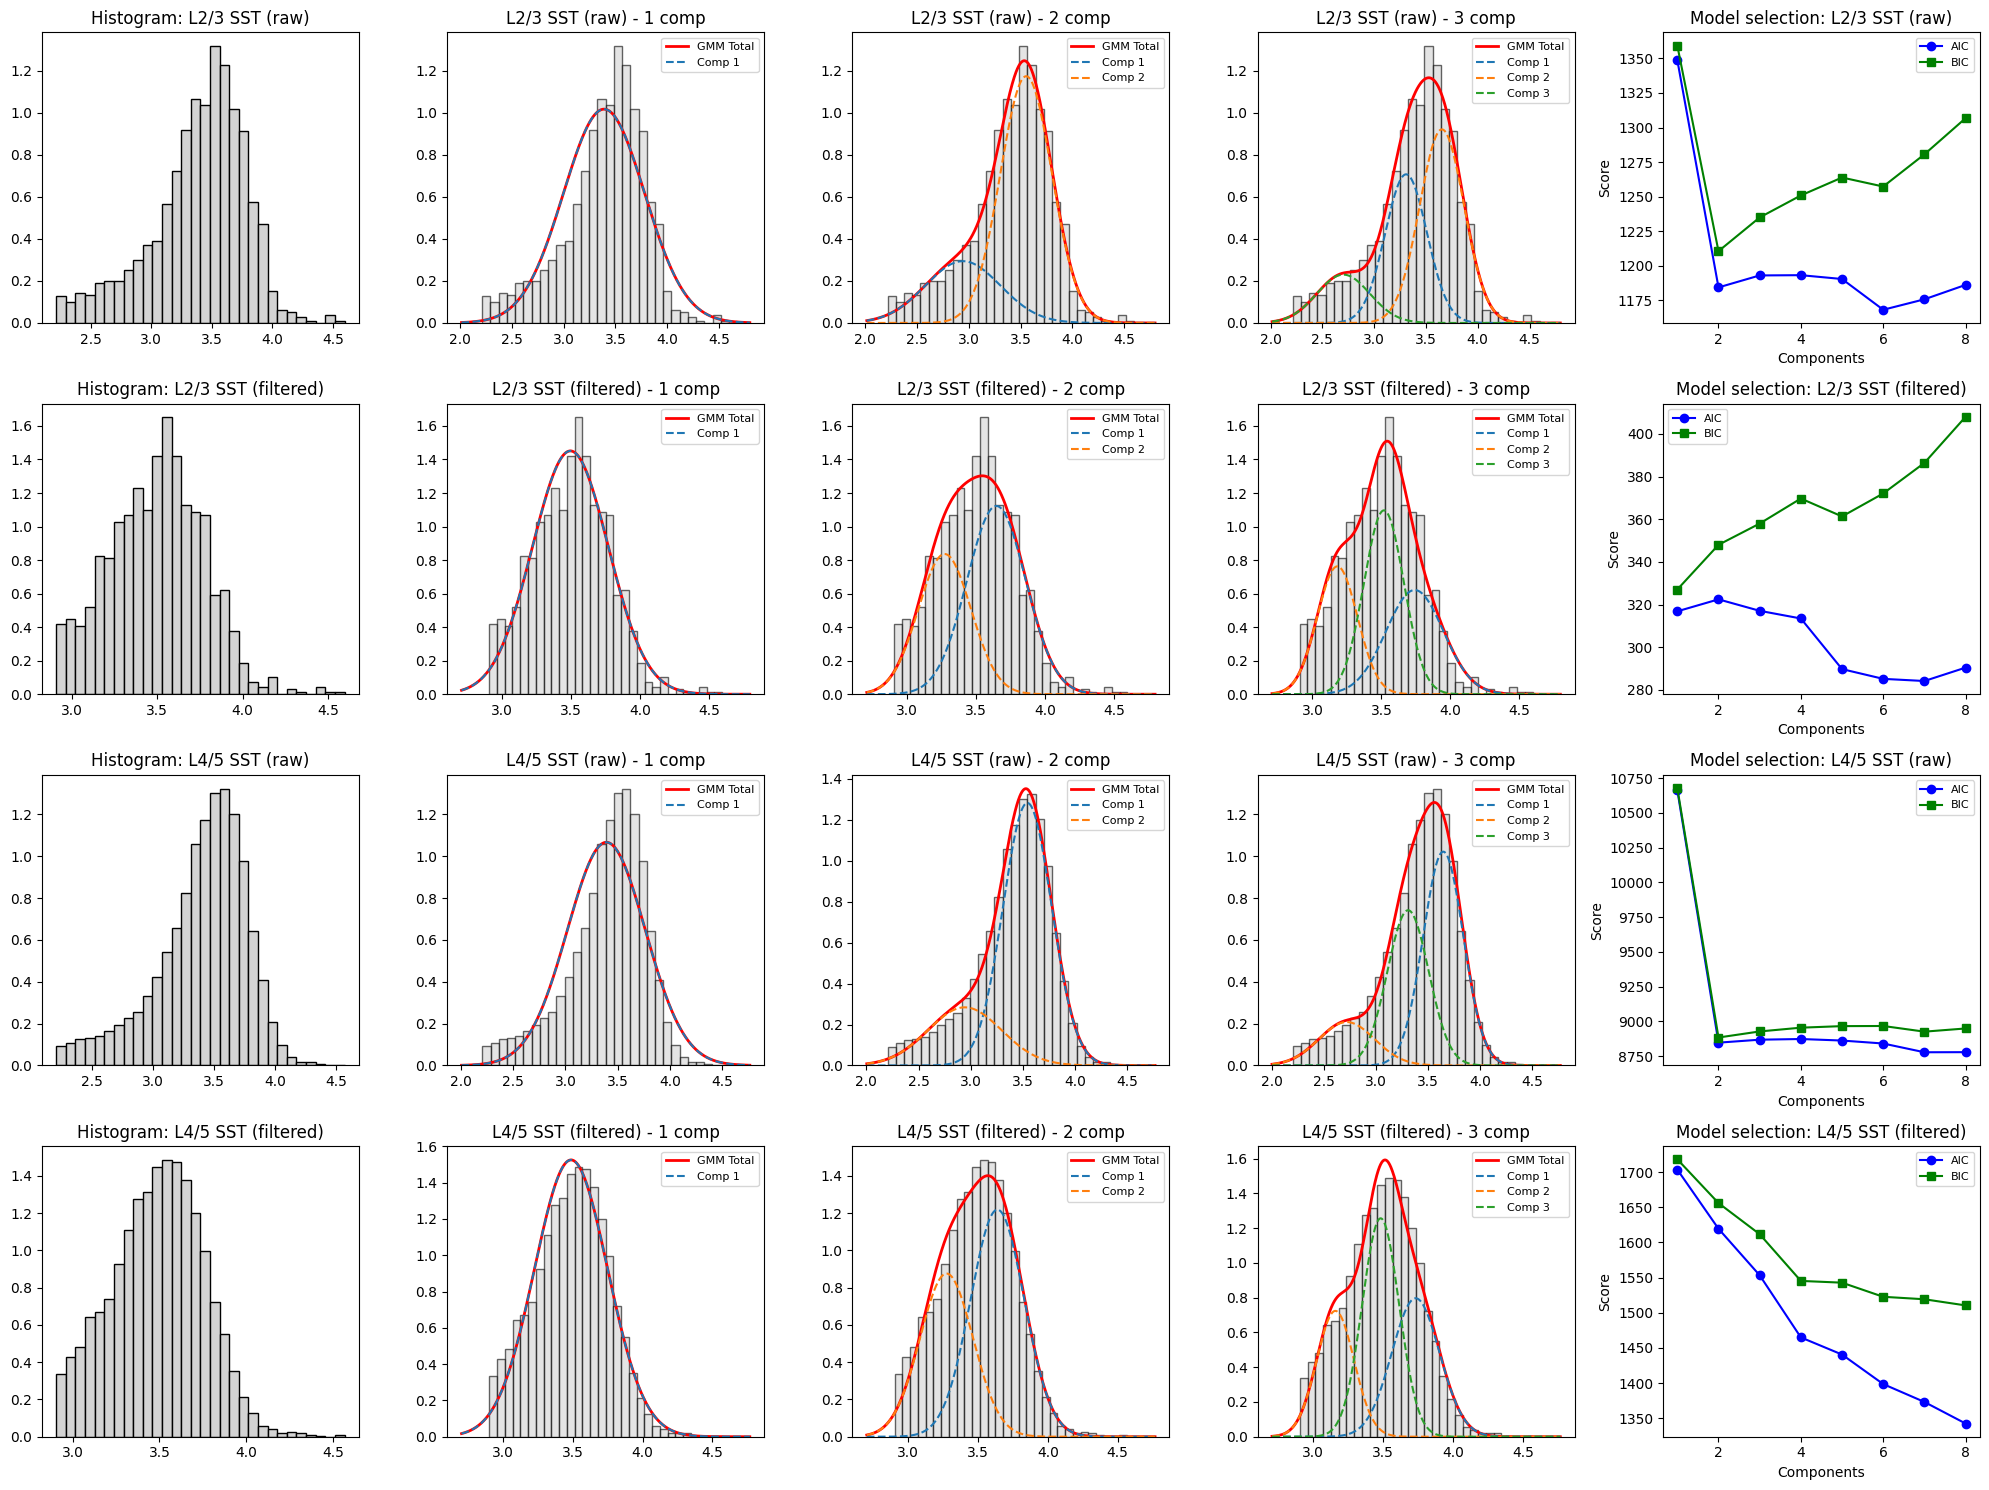

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

# Define datasets and labels
datasets = [l23_sizes, l23_sizes_filtered, l45_sizes, l45_sizes_filtered]
labels = [
    'L2/3 SST (raw)',
    'L2/3 SST (filtered)',
    'L4/5 SST (raw)',
    'L4/5 SST (filtered)'
]
component_counts = [1, 2, 3]
model_selection_range = range(1, 9)

# Create subplot grid
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 15))

for row, (sizes, label) in enumerate(zip(datasets, labels)):
    log_data = np.log10(sizes).reshape(-1, 1)
    x_vals = np.linspace(log_data.min() - 0.2, log_data.max() + 0.2, 1000).reshape(-1, 1)

    # Column 0: Histogram
    ax = axes[row, 0]
    ax.hist(log_data, bins=30, density=True, color='lightgrey', edgecolor='black')
    ax.set_title(f'Histogram: {label}')

    # Columns 1–3: GMM fits
    for col, n_components in enumerate(component_counts, start=1):
        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(log_data)
        logprob = gmm.score_samples(x_vals)
        total_pdf = np.exp(logprob)

        ax = axes[row, col]
        ax.hist(log_data, bins=30, density=True, color='lightgrey', edgecolor='black', alpha=0.6)
        ax.plot(x_vals, total_pdf, color='r', lw=2, label='GMM Total')

        for i in range(n_components):
            mean = gmm.means_[i, 0]
            std = np.sqrt(gmm.covariances_[i, 0, 0]) if gmm.covariance_type == 'full' else np.sqrt(gmm.covariances_[i])
            weight = gmm.weights_[i]
            component_pdf = weight * norm.pdf(x_vals.flatten(), loc=mean, scale=std)
            ax.plot(x_vals, component_pdf, lw=1.5, linestyle='--', label=f'Comp {i+1}')

        ax.set_title(f'{label} - {n_components} comp')
        ax.legend(fontsize=8)

    # Column 4: GMM AIC/BIC scores
    aic_vals = []
    bic_vals = []

    for k in model_selection_range:
        gmm = GaussianMixture(n_components=k, random_state=0)
        gmm.fit(log_data)
        aic_vals.append(gmm.aic(log_data))
        bic_vals.append(gmm.bic(log_data))

    ax = axes[row, 4]
    ax.plot(model_selection_range, aic_vals, 'o-', label='AIC', color='blue')
    ax.plot(model_selection_range, bic_vals, 's-', label='BIC', color='green')
    ax.set_title(f'Model selection: {label}')
    ax.set_xlabel('Components')
    ax.set_ylabel('Score')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()
